In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [23]:
df = pd.read_csv('C:/Users/shail/Desktop/project/raw data/Device-1.csv')

df.columns = ['SNo','temp','hum','co','no2','pm2_5','pm10','date']
date = df['date']
df = df.drop(["SNo"],axis=1)
df['date'] = pd.to_datetime(df['date'])

In [24]:
df.head()

,temp,hum,co,no2,pm2_5,pm10,date
0,15,50,40,1.31,53,74,2020-01-11 17:08:19
1,15,50,40,1.32,53,74,2020-01-11 17:08:13
2,15,50,40,1.32,53,74,2020-01-11 17:08:09
3,15,50,40,1.32,53,74,2020-01-11 17:08:03
4,15,50,40,1.32,53,74,2020-01-11 17:07:59


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872050 entries, 0 to 872049
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   temp    872050 non-null  int64         
 1   hum     872050 non-null  int64         
 2   co      872050 non-null  int64         
 3   no2     872050 non-null  float64       
 4   pm2_5   872050 non-null  int64         
 5   pm10    872050 non-null  int64         
 6   date    872050 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 46.6 MB


In [26]:
df = df[(df['co'] > 0) & (df['no2'] > 0) & (df['pm2_5'] > 0) & (df['pm10'] > 0)]

In [27]:
temp_one_hr = round(df.resample('60min',on='date').temp.mean(),2)
hum_one_hr = round(df.resample('60min',on='date').hum.mean(),2)
co_one_hr = round(df.resample('60min',on='date').co.mean(),2)
no2_one_hr = round(df.resample('60min',on='date').no2.mean(),2)
pm2_5_one_hr = round(df.resample('60min',on='date').pm2_5.mean(),2)
pm10_one_hr = round(df.resample('60min',on='date').pm10.mean(),2)

one_hr_sample = pd.DataFrame({
    "TEMP":temp_one_hr,
    "HUM":hum_one_hr,
    "CO":co_one_hr,
    "NO2":no2_one_hr,
    "PM2.5":pm2_5_one_hr,
    "PM10":pm10_one_hr
})

one_hr_sample

,TEMP,HUM,CO,NO2,PM2.5,PM10
date,,,,,,
2019-09-13 11:00:00,20.72,45.55,5.50,19.41,20.07,28.07
2019-09-13 12:00:00,21.68,45.55,5.22,19.42,21.99,30.39
2019-09-13 13:00:00,22.19,43.53,5.67,19.43,22.63,31.49
2019-09-13 14:00:00,21.73,44.27,4.93,19.42,24.61,34.45
2019-09-13 15:00:00,19.29,54.04,6.34,19.40,28.56,39.77
...,...,...,...,...,...,...
2020-01-11 13:00:00,17.92,44.29,40.00,1.38,66.62,92.64
2020-01-11 14:00:00,17.50,42.56,40.00,1.41,57.87,80.33
2020-01-11 15:00:00,16.74,44.00,40.00,1.45,53.99,74.98


In [28]:
pm = one_hr_sample[['PM2.5']].copy()

In [29]:
pm

,PM2.5
date,
2019-09-13 11:00:00,20.07
2019-09-13 12:00:00,21.99
2019-09-13 13:00:00,22.63
2019-09-13 14:00:00,24.61
2019-09-13 15:00:00,28.56
...,...
2020-01-11 13:00:00,66.62
2020-01-11 14:00:00,57.87
2020-01-11 15:00:00,53.99


In [30]:
df = pm.copy()

In [31]:
#df = df[:2886]
df

,PM2.5
date,
2019-09-13 11:00:00,20.07
2019-09-13 12:00:00,21.99
2019-09-13 13:00:00,22.63
2019-09-13 14:00:00,24.61
2019-09-13 15:00:00,28.56
...,...
2020-01-11 13:00:00,66.62
2020-01-11 14:00:00,57.87
2020-01-11 15:00:00,53.99


In [32]:
df.isna().sum()

PM2.5    1439
dtype: int64

In [33]:
df = df.interpolate(method ='linear')

<AxesSubplot:xlabel='date'>

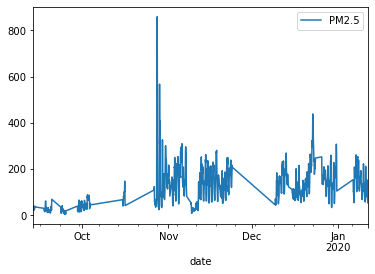

In [34]:
df.plot()

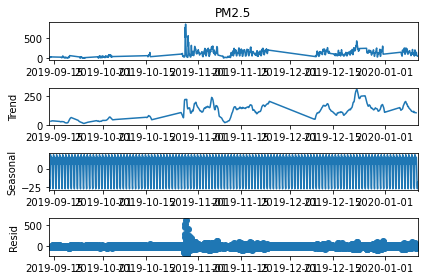

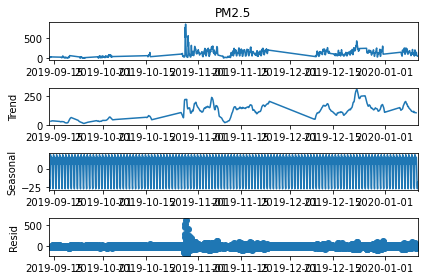

In [35]:
results = seasonal_decompose(df['PM2.5'], freq=24)
results.plot()

In [36]:
len(df)

2887

In [37]:
train = df.iloc[:2863]
test = df.iloc[2863:]

scaler = MinMaxScaler()

In [38]:
df.head(), df.tail()

(                     PM2.5
 date                      
 2019-09-13 11:00:00  20.07
 2019-09-13 12:00:00  21.99
 2019-09-13 13:00:00  22.63
 2019-09-13 14:00:00  24.61
 2019-09-13 15:00:00  28.56,
                      PM2.5
 date                      
 2020-01-11 13:00:00  66.62
 2020-01-11 14:00:00  57.87
 2020-01-11 15:00:00  53.99
 2020-01-11 16:00:00  52.26
 2020-01-11 17:00:00  53.56)

In [39]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.01930962],
       [0.02155248],
       [0.0223001 ],
       [0.02461305],
       [0.02922726],
       [0.03384148],
       [0.04062847],
       [0.02816424],
       [0.02189124],
       [0.02260382]])

# Recursive Strategy

In [40]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.01930962],
         [0.02155248],
         [0.0223001 ],
         [0.02461305],
         [0.02922726],
         [0.03384148],
         [0.04062847],
         [0.02816424],
         [0.02189124],
         [0.02260382],
         [0.02656387],
         [0.02984639],
         [0.03976403],
         [0.03946031],
         [0.03545354],
         [0.04034811],
         [0.03955376],
         [0.03714736],
         [0.03705625],
         [0.03696513],
         [0.03687401],
         [0.0367829 ],
         [0.03669178],
         [0.03660067]]]),
 array([[0.03650955]]))

In [41]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(generator, epochs=10, verbose=1)

Epoch 1/10
2839/2839 [==============================] - 32s 10ms/step - loss: 0.0023
Epoch 2/10
2839/2839 [==============================] - 29s 10ms/step - loss: 0.0010
Epoch 3/10
2839/2839 [==============================] - 30s 11ms/step - loss: 8.9415e-04
Epoch 4/10
2839/2839 [==============================] - 32s 11ms/step - loss: 7.9042e-04
Epoch 5/10
2839/2839 [==============================] - 32s 11ms/step - loss: 6.3491e-04
Epoch 6/10
2839/2839 [==============================] - 32s 11ms/step - loss: 9.1674e-04
Epoch 7/10
2839/2839 [==============================] - 32s 11ms/step - loss: 4.7612e-04
Epoch 8/10
2839/2839 [==============================] - 32s 11ms/step - loss: 7.8479e-04
Epoch 9/10
2839/2839 [==============================] - 32s 11ms/step - loss: 5.3301e-04
Epoch 10/10
2839/2839 [==============================] - 32s 11ms/step - loss: 6.6061e-04


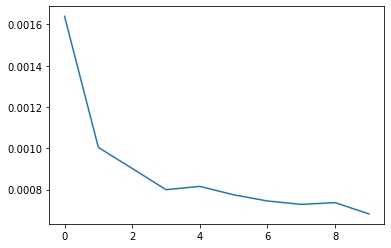

In [43]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [44]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.08486632]], dtype=float32)

In [45]:
scaled_test[0], scaled_test[1]

(array([0.11799544]), array([0.18851703]))

In [46]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.08486632], dtype=float32),
 array([0.0914579], dtype=float32),
 array([0.09561844], dtype=float32),
 array([0.09753516], dtype=float32),
 array([0.09827799], dtype=float32),
 array([0.09895188], dtype=float32),
 array([0.10027478], dtype=float32),
 array([0.1023092], dtype=float32),
 array([0.10476705], dtype=float32),
 array([0.10728566], dtype=float32),
 array([0.10961036], dtype=float32),
 array([0.11165263], dtype=float32),
 array([0.11345541], dtype=float32),
 array([0.11511939], dtype=float32),
 array([0.11673698], dtype=float32),
 array([0.11835834], dtype=float32),
 array([0.1199899], dtype=float32),
 array([0.12161103], dtype=float32),
 array([0.12319482], dtype=float32),
 array([0.12472227], dtype=float32),
 array([0.12618712], dtype=float32),
 array([0.12759328], dtype=float32),
 array([0.12894933], dtype=float32),
 array([0.13026348], dtype=float32)]

In [47]:
test.head()

,PM2.5
date,
2020-01-10 18:00:00,104.55
2020-01-10 19:00:00,164.92
2020-01-10 20:00:00,211.35
2020-01-10 21:00:00,141.20
2020-01-10 22:00:00,121.06


In [48]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

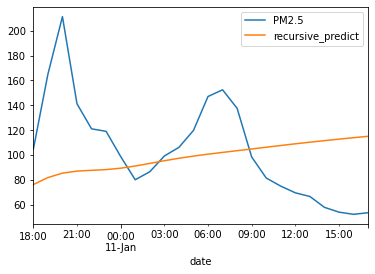

In [49]:
test.plot()

In [50]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['recursive_predict']))
print(rmse)

47.56905490400867


In [51]:
test

,PM2.5,recursive_predict
date,,
2020-01-10 18:00:00,104.55,76.189809
2020-01-10 19:00:00,164.92,81.832538
2020-01-10 20:00:00,211.35,85.394167
2020-01-10 21:00:00,141.20,87.034970
2020-01-10 22:00:00,121.06,87.670870
2020-01-10 23:00:00,119.04,88.247754
2020-01-11 00:00:00,98.77,89.380224
2020-01-11 01:00:00,80.07,91.121795
2020-01-11 02:00:00,86.52,93.225830


# Direct Startegy

In [52]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [53]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [54]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.07418448], dtype=float32),
 array([0.1111533], dtype=float32),
 array([0.12528037], dtype=float32),
 array([0.1066903], dtype=float32),
 array([0.13270858], dtype=float32),
 array([0.15586141], dtype=float32),
 array([0.15526721], dtype=float32),
 array([0.16325717], dtype=float32),
 array([0.1398445], dtype=float32),
 array([0.12928241], dtype=float32),
 array([0.14983943], dtype=float32),
 array([0.11991017], dtype=float32),
 array([0.14040703], dtype=float32),
 array([0.15925129], dtype=float32),
 array([0.09874257], dtype=float32),
 array([0.10821271], dtype=float32),
 array([0.12013597], dtype=float32),
 array([0.11259069], dtype=float32),
 array([0.1042766], dtype=float32),
 array([0.12376004], dtype=float32),
 array([0.09517863], dtype=float32),
 array([0.09852502], dtype=float32),
 array([0.09346238], dtype=float32),
 array([0.09065542], dtype=float32)]

In [55]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

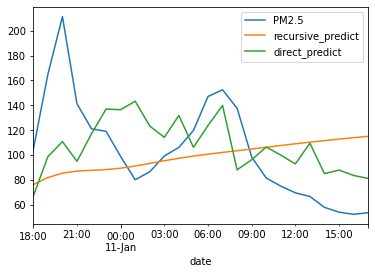

In [56]:
test.plot()

In [57]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_predict']))
print(rmse)

39.06836439361655


In [58]:
test

,PM2.5,recursive_predict,direct_predict
date,,,
2020-01-10 18:00:00,104.55,76.189809,67.045622
2020-01-10 19:00:00,164.92,81.832538,98.692786
2020-01-10 20:00:00,211.35,85.394167,110.786257
2020-01-10 21:00:00,141.20,87.034970,94.872233
2020-01-10 22:00:00,121.06,87.670870,117.145179
2020-01-10 23:00:00,119.04,88.247754,136.965158
2020-01-11 00:00:00,98.77,89.380224,136.456494
2020-01-11 01:00:00,80.07,91.121795,143.296298
2020-01-11 02:00:00,86.52,93.225830,123.253890


# Direct Recursive Startegy

In [59]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [60]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [61]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.08701425], dtype=float32),
 array([0.0889023], dtype=float32),
 array([0.09371018], dtype=float32),
 array([0.10258907], dtype=float32),
 array([0.110614], dtype=float32),
 array([0.11692544], dtype=float32),
 array([0.11854862], dtype=float32),
 array([0.10694307], dtype=float32),
 array([0.11705755], dtype=float32),
 array([0.12117421], dtype=float32),
 array([0.11150634], dtype=float32),
 array([0.13057669], dtype=float32),
 array([0.14194535], dtype=float32),
 array([0.1202958], dtype=float32),
 array([0.12165014], dtype=float32),
 array([0.1319478], dtype=float32),
 array([0.12017237], dtype=float32),
 array([0.12512074], dtype=float32),
 array([0.11701664], dtype=float32),
 array([0.12642546], dtype=float32),
 array([0.10179558], dtype=float32),
 array([0.10833962], dtype=float32),
 array([0.12617774], dtype=float32),
 array([0.12072013], dtype=float32)]

In [62]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

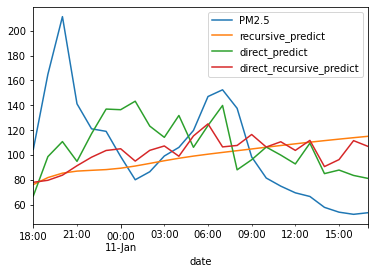

In [63]:
test.plot()

In [64]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_recursive_predict']))
print(rmse)

43.93971268930352


In [65]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict
date,,,,
2020-01-10 18:00:00,104.55,76.189809,67.045622,78.028549
2020-01-10 19:00:00,164.92,81.832538,98.692786,79.644816
2020-01-10 20:00:00,211.35,85.394167,110.786257,83.760603
2020-01-10 21:00:00,141.20,87.034970,94.872233,91.361374
2020-01-10 22:00:00,121.06,87.670870,117.145179,98.231116
2020-01-10 23:00:00,119.04,88.247754,136.965158,103.634024
2020-01-11 00:00:00,98.77,89.380224,136.456494,105.023543
2020-01-11 01:00:00,80.07,91.121795,143.296298,95.088616
2020-01-11 02:00:00,86.52,93.225830,123.253890,103.747119


# MIMO

In [66]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [67]:
n_input = 24
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [68]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [69]:
model.fit(X, y, epochs=3, verbose=0)

In [70]:
model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_50 (Dense)             (None, 24)                4824      
Total params: 166,424
Trainable params: 166,424
Non-trainable params: 0
_________________________________________________________________


In [71]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [72]:
res.shape

(24, 1)

In [73]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [74]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
date,,,,,
2020-01-10 18:00:00,104.55,76.189809,67.045622,78.028549,85.068443
2020-01-10 19:00:00,164.92,81.832538,98.692786,79.644816,91.302292
2020-01-10 20:00:00,211.35,85.394167,110.786257,83.760603,104.261391
2020-01-10 21:00:00,141.20,87.034970,94.872233,91.361374,97.049576
2020-01-10 22:00:00,121.06,87.670870,117.145179,98.231116,106.081772
2020-01-10 23:00:00,119.04,88.247754,136.965158,103.634024,107.136887
2020-01-11 00:00:00,98.77,89.380224,136.456494,105.023543,108.801575
2020-01-11 01:00:00,80.07,91.121795,143.296298,95.088616,108.861923
2020-01-11 02:00:00,86.52,93.225830,123.253890,103.747119,108.982368


<AxesSubplot:xlabel='date'>

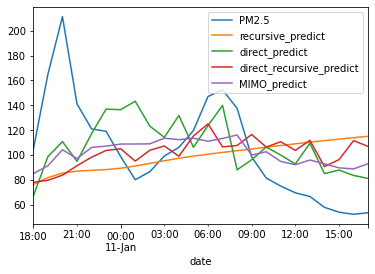

In [75]:
test.plot()

In [76]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['MIMO_predict']))
print(rmse)

36.63034884057802


# Direct MIMO

In [77]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [78]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [83]:
n_input = 12
n_features = 1
test_predictions = []

q = int(len(scaled_test)/4)

n_output = q

for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.07793869, 0.08491721, 0.09533188, 0.10553111, 0.1074985 ,
         0.10989892]], dtype=float32),
 array([[0.15164313, 0.15014768, 0.15287152, 0.15245299, 0.15140277,
         0.14952116]], dtype=float32),
 array([[0.13371618, 0.13083352, 0.1303435 , 0.13877296, 0.13337165,
         0.13231644]], dtype=float32),
 array([[0.108464  , 0.1026604 , 0.0999949 , 0.09678162, 0.08797863,
         0.09331675]], dtype=float32),
 array([[0.09690911, 0.0991304 , 0.10307395, 0.10411263, 0.10397749,
         0.1055245 ]], dtype=float32),
 array([[0.11326189, 0.11586719, 0.11919577, 0.11878791, 0.11967532,
         0.12220628]], dtype=float32)]

In [84]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [85]:
res = np.array(res[:len(scaled_test)])
res = res.reshape((res.shape[0],1))
res.shape

(24, 1)

In [86]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [87]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
date,,,,,,
2020-01-10 18:00:00,104.55,76.189809,67.045622,78.028549,85.068443,70.259415
2020-01-10 19:00:00,164.92,81.832538,98.692786,79.644816,91.302292,76.233376
2020-01-10 20:00:00,211.35,85.394167,110.786257,83.760603,104.261391,85.148857
2020-01-10 21:00:00,141.20,87.034970,94.872233,91.361374,97.049576,93.879906
2020-01-10 22:00:00,121.06,87.670870,117.145179,98.231116,106.081772,95.564087
2020-01-10 23:00:00,119.04,88.247754,136.965158,103.634024,107.136887,97.618973
2020-01-11 00:00:00,98.77,89.380224,136.456494,105.023543,108.801575,133.354095
2020-01-11 01:00:00,80.07,91.121795,143.296298,95.088616,108.861923,132.073914
2020-01-11 02:00:00,86.52,93.225830,123.253890,103.747119,108.982368,134.405655


<AxesSubplot:xlabel='date'>

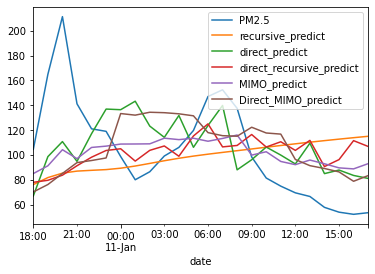

In [88]:
test.plot()

In [89]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['Direct_MIMO_predict']))
print(rmse)

44.677704174818004


In [90]:
rec_err = abs(test['PM2.5'] - test['recursive_predict'])
dir_err = abs(test['PM2.5'] - test['direct_predict'])
dir_rec_err = abs(test['PM2.5'] - test['direct_recursive_predict'])
mimo_err = abs(test['PM2.5'] - test['MIMO_predict'])
dir_mimo_err = abs(test['PM2.5'] - test['Direct_MIMO_predict'])

In [91]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [92]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
date,,,,,
2020-01-10 18:00:00,28.360191,37.504378,26.521451,19.481557,34.290585
2020-01-10 19:00:00,83.087462,66.227214,85.275184,73.617708,88.686624
2020-01-10 20:00:00,125.955833,100.563743,127.589397,107.088609,126.201143
2020-01-10 21:00:00,54.165030,46.327767,49.838626,44.150424,47.320094
2020-01-10 22:00:00,33.389130,3.914821,22.828884,14.978228,25.495913
2020-01-10 23:00:00,30.792246,17.925158,15.405976,11.903113,21.421027
2020-01-11 00:00:00,9.389776,37.686494,6.253543,10.031575,34.584095
2020-01-11 01:00:00,11.051795,63.226298,15.018616,28.791923,52.003914
2020-01-11 02:00:00,6.705830,36.733890,17.227119,22.462368,47.885655


<AxesSubplot:xlabel='date'>

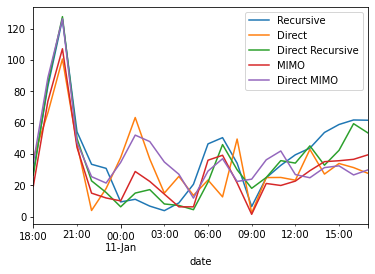

In [93]:
errors.plot()

In [94]:
len(scaled_test)

24